In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
import tensorflow as tf

tweetsTrain = pd.read_json('trainData.json')
tweetsTest = pd.read_json('testData.json')

def form_sentence(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", '', tweet)
    tweet = re.sub(r'<[^>]+>', '', tweet)
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)
    

def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess


def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet


# Final_words = []
# for data in tweetsTrain['Content']:
#     filtered = normalization(no_user_alpha(form_sentence(data)))
#     word_Final = ' '.join(filtered)
#     Final_words.append(word_Final)

# final_bodyTrain = pd.DataFrame(Final_words, columns=['Content'])
# print(final_bodyTrain)
# Final_wordss = []
# for data in tweetsTest['Content']:
#     filtered = normalization(no_user_alpha(form_sentence(data)))
#     word_Final = ' '.join(filtered)
#     Final_wordss.append(word_Final)

# final_bodyTest = pd.DataFrame(Final_wordss, columns=['Content'])

# BlackPanther = pd.read_json('BlackPanther.json')

# Final_words = []
# for data in BlackPanther['Content']:
#     filtered = normalization(no_user_alpha(form_sentence(data)))
#     word_Final = ' '.join(filtered)
#     Final_words.append(word_Final)

# final_BlackPanther = pd.DataFrame(Final_words, columns=['Content'])

In [2]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

X_train = final_bodyTrain['Content']
print(type(X_train))
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(tweetsTrain['Sentiment'])
# Y_train = np.array(label_tokenizer.texts_to_sequences(tweetsTrain['Sentiment']))

X_test = final_bodyTest['Content']
X_BlackPanther = final_BlackPanther['Content']
# label_tokenizer.fit_on_texts(tweetsTest['Sentiment'])
# Y_test = np.array(label_tokenizer.texts_to_sequences(tweetsTest['Sentiment']))

NameError: name 'final_bodyTrain' is not defined

In [8]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
total_reviews = X_train + X_test
total_reviews = total_reviews.astype(str)
tokenizer_obj.fit_on_texts(total_reviews)

max_length = max([len(s.split()) for s in total_reviews])
print(max_length)

vocab_size = len(tokenizer_obj.word_index) + 1
print(vocab_size)

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen = max_length, padding = 'post')
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_length, padding = 'post')
print(X_test_pad[500][0])

43
2884
17


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.regularizers import l2

EMBEDDING_DIM = 100

print('Build model...')
callback = EarlyStopping(monitor='val_loss')
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length))
model.add(Bidirectional(GRU(units=64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6))))
model.add(Dense(128, input_dim=2, activation='relu', kernel_regularizer=l2(1e-6)))
model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(1e-6)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 100)           288400    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               63744     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               64500     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3006      
Total params: 436,162
Trainable params: 436,162
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
print('Train...')

mod = model.fit(X_train_pad, tweetsTrain['Sentiment'], epochs=5, validation_data=(X_test_pad, tweetsTest['Sentiment']), callbacks=[callback], verbose=2)
len(mod.history['loss'])

Train...
Epoch 1/5
152/152 - 12s - loss: 0.8835 - accuracy: 0.5823 - val_loss: 0.5214 - val_accuracy: 0.7655
Epoch 2/5
152/152 - 10s - loss: 0.3976 - accuracy: 0.8361 - val_loss: 0.4126 - val_accuracy: 0.8224
Epoch 3/5
152/152 - 10s - loss: 0.3016 - accuracy: 0.8784 - val_loss: 0.4574 - val_accuracy: 0.8172


3

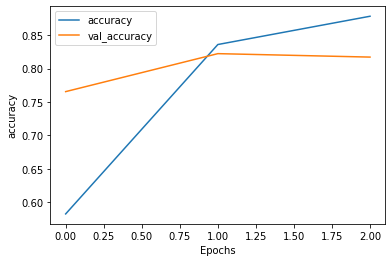

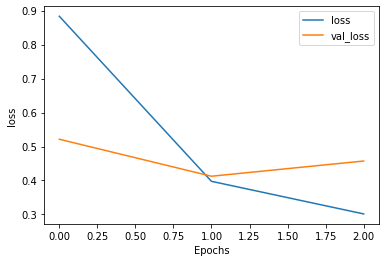

In [6]:
import matplotlib.pyplot as plt
def plot_graphs(mod, string):
  plt.plot(mod.history[string])
  plt.plot(mod.history["val_" + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(mod, "accuracy")
plot_graphs(mod, "loss")

In [7]:
loss, accuracy = model.evaluate(X_test_pad, tweetsTest['Sentiment'])
print('Accuracy: %f' % (accuracy*100))

19/19 [==============================] - 0s 8ms/step - loss: 0.4574 - accuracy: 0.8172
Accuracy: 81.724137


In [8]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

x=[X_test_pad]
# predict probabilities for test set
yhat_probs = model.predict(x, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(tweetsTest['Sentiment'], yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(tweetsTest['Sentiment'], yhat_classes, average = 'weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(tweetsTest['Sentiment'], yhat_classes, average = 'weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(tweetsTest['Sentiment'], yhat_classes, average = 'weighted')
print('F1 score: %f' % f1)

confusion_matrix = confusion_matrix(tweetsTest['Sentiment'], yhat_classes)
print(confusion_matrix)
negative = confusion_matrix[2][2]
print(confusion_matrix[1][1])
print(negative)

Accuracy: 0.817241
Precision: 0.818515
Recall: 0.817241
F1 score: 0.816302
[[243  50   7]
 [ 39 151  10]
 [  0   0  80]]
151
80


In [26]:
model.save('lstm_model.h5')

NameError: name 'model' is not defined

In [28]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.regularizers import l2
model = Sequential()
CATEGORIES = ['Neutral', 'Positive', 'Negative']
model = load_model('lstm_model.h5')

ValueError: Unknown regularizer: L2

In [15]:
import json,os
    
path_to_json = 'JS/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

for js in json_files:
    with open(os.path.join(path_to_json, js), 'r') as json_file:
        predictData = pd.read_json(json_file)
        
        Final_words = []
        for data in predictData['Content']:
            filtered = normalization(no_user_alpha(form_sentence(data)))
            word_Final = ' '.join(filtered)
            Final_words.append(word_Final)

        final_predictData = pd.DataFrame(Final_words, columns=['Content'])

        predictData_tokens = tokenizer_obj.texts_to_sequences(final_predictData['Content'])
        predictData_pad = pad_sequences(predictData_tokens, maxlen = max_length, padding = 'post')
        
        predict = model.predict_classes(predictData_pad, verbose=0)
        count_positive=0
        count_negative=0
        count_neutral=0

        for x in predict:
            if x == 0:
                count_neutral+=1
            if x == 1:
                count_positive+=1
            if x == 2:
                count_negative+=1
                
        if (count_negative == 0) & (count_positive == 0) :
            print(json_file.name)
            continue
        else :
        
            ratio1 = (count_positive) / (count_negative + count_positive)
#             ratio2 = (count_positive + count_neutral) / (count_negative + count_positive + count_neutral)
            ratio3 = (count_negative)/(count_negative + count_positive)
        
#         ratio1 = round(ratio,2)
        if ratio1 > 0.94 : 
            predicted_value1 = 1
        else : 
            predicted_value1 = 0
            
        if (ratio3 * 100) > 4.00 :
              predicted_value2 = 0
        else : 
              predicted_value2 = 1

        if predicted_value1 == 1 or predicted_value2 == 1:
              predicted_value3 = 1
        else :
              predicted_value3 = 0

        with open("/content/drive/My Drive/Research/Data/Preprocessed/pred_val_0.txt", "a") as text_file:
            print(format(json_file.name) + '  pred_val: '+format(predicted_value3)
                      , file=text_file)

NameError: name 'model' is not defined